## Project_5:  Testing Ground Advanced Edition

### Importing ALL libraries and packages

####  Cell 1:

In [1]:
# Import all necessary libraries and packages
import os
import cv2
import time
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import background as bg  # import background.py

from sklearn.calibration import CalibratedClassifierCV
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

#from sklearn import svm, grid_search, datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Defining Functions

####  Cell 2:

In [4]:

def load_car(path=''):
    images = glob.glob(path)
    cars = []
    for image in images:
        cars.append(image)
    print("There are ",len(cars),"images that belong to category 'car'.")
    
    return cars

#_______________________________________________________________________________________
def load_notcars(path=''):
    images = glob.glob(path)
    notcars = []
    for image in images:
        notcars.append(image)
    print("There are ",len(notcars),"images that belong to category 'non-car'.")
    return notcars
    
#_______________________________________________________________________________________

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#_______________________________________________________________________________________

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


#_______________________________________________________________________________________

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#_______________________________________________________________________________________

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
       
        # apply color conversion if other than 'RGB'
        '''
        if cspace != 'RGB':
            change_cspace = "cv2.COLOR_RGB2" + cspace
            feature_image = cv2.cvtColor(image, eval(change_cspace))
        else: feature_image = np.copy(image)      
        '''
        
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 
        
        
        # Get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Get color histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Get HoG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append features
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        #features.append(np.concatenate((hist_features,hog_features)))
        
    return features


#_______________________________________________________________________________________

# Function to extract features from a single image
def extract_features_single(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    image = img

    # apply color conversion if other than 'RGB'
    '''
    if cspace != 'RGB':
        change_cspace = "cv2.COLOR_RGB2" + cspace
        feature_image = cv2.cvtColor(image, eval(change_cspace))
    else: feature_image = np.copy(image) 
    '''
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

     

    # Get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # Get color histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Get HoG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Append features
    features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    #features.append(np.concatenate((hist_features,hog_features)))
        
    return features

#_______________________________________________________________________________________

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#_______________________________________________________________________________________
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#_______________________________________________________________________________________

def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using extract_features_single()
        features = extract_features_single(img=test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#_______________________________________________________________________________________

# Heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    # plt.imshow(heatmap)
    return heatmap# Iterate through list of bboxes


#_______________________________________________________________________________________
# Threshold image
def apply_threshold(heatmap, threshold):
    new_heatmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    new_heatmap[new_heatmap <= threshold] = 0
    # Return thresholded map
    return new_heatmap
#_______________________________________________________________________________________
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img   
#_______________________________________________________________________________________
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV) 

#_______________________________________________________________________________________
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
                bbox_list.append(((xbox_left, ytop_draw + ystart),
                                 (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                
    return draw_img, bbox_list

#_______________________________________________________________________________________

def disp_img(original_image, augmented_image, aug_title = ""):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    #f.tight_layout()
    ax1.imshow(original_image)
    ax2.imshow(augmented_image)
    ax1.set_title('Original Image', fontsize=20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax2.set_title(aug_title, fontsize=20)
    
    plt.show()

#### Import Project Images

####  Cell 3


In [5]:
# import car images
cars = load_car(path='vehicles/*/*.png')
# import non-car images
notcars = load_notcars(path='non-vehicles/*/*.png')

There are  8792 images that belong to category 'car'.
There are  8968 images that belong to category 'non-car'.


<br><br>
#### Cell 4

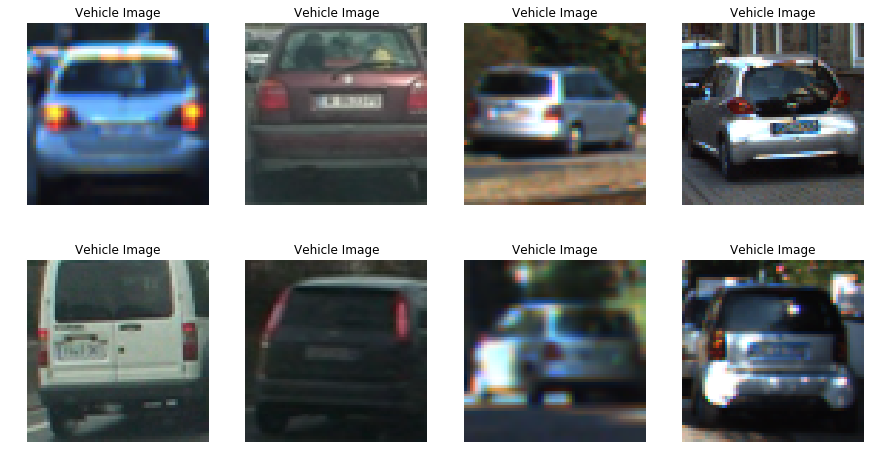

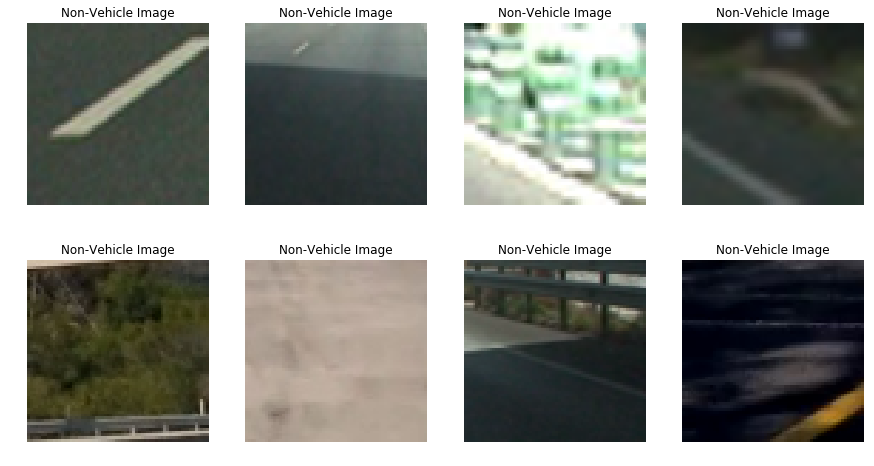

In [6]:
### Plot images from dataset randomly
fig = plt.figure(figsize=(15, 8))

for A in range(8):
    image = fig.add_subplot(2,4,A+1)
    idx = np.random.randint(1,len(cars))
    plt.imshow(mpimg.imread(cars[idx])) 
    image.set_title("Vehicle Image")
    #img.set_xticks([])
    #img.set_yticks([])
    plt.axis('off')
plt.show()

### Plot random images from dataset
fig = plt.figure(figsize=(15, 8))

for B in range(8):
    image = fig.add_subplot(2,4,B+1)
    idx = np.random.randint(1,len(notcars))
    plt.imshow(mpimg.imread(notcars[idx]))   
    image.set_title("Non-Vehicle Image")
    plt.axis('off')
plt.show()

<br><br>
#### Cell 5

In [7]:
### defining Parameters
cspace ='YCrCb'
cell_per_block = 2
hist_bins = 32
hist_range = (0, 256)
hog_channel = 'ALL'
orient = 9
pix_per_cell = 8
spatial_size = (16, 16)


<br><br>
#### Cell 6

In [ ]:
for A in range(0,len(cars),len(cars)//8):
    image_single= mpimg.imread(cars[A])
    #gray = cv2.cvtColor(image_single, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(img = image_single[:,:,2], orient=orient, pix_per_cell=pix_per_cell,
                                              cell_per_block=cell_per_block, vis=True, feature_vec=False)
    disp_img(image_single, hog_image, "HOG")

####  This section can be ignored. (only used for CrowdAI DATA)

In [ ]:
dataset = pd.read_csv('E:/udacity_data/labels/labels_car_short.csv')

xmin = dataset.iloc[:,0].values
xmax = dataset.iloc[:,1].values
ymin = dataset.iloc[:,2].values
ymax = dataset.iloc[:,3].values


X = dataset.iloc[:, 7].values
file_name = dataset.iloc[:, 4].values

In [ ]:
if not os.path.isdir("E:/udacity_data/out_training_images"):   # if the folder called 'output_images' does not exist, create this folder
    os.mkdir("E:/udacity_data/out_training_images")

for i in range(len(X)):
    
    img = mpimg.imread(X[i])
        
    if ymin[i] < ymax[i] and xmin[i] < xmax[i]:
        
        crop_img = img[ymin[i]:ymax[i],xmin[i]:xmax[i]]
        img_resized = cv2.resize(crop_img, (64,64))
        mpimg.imsave(os.path.join("E:/udacity_data/out_training_images/", file_name[i]), img_resized)

    elif ymin[i] < ymax[i] and xmin[i] > xmax[i]:
        
        
        crop_img = img[ymin[i]:ymax[i],xmax[i]:xmin[i]]
        img_resized = cv2.resize(crop_img, (64,64))
        mpimg.imsave(os.path.join("E:/udacity_data/out_training_images/", file_name[i]), img_resized)
    
    elif ymin[i] > ymax[i] and xmin[i] > xmax[i]:

        crop_img = img[ymax[i]:ymin[i],xmax[i]:xmin[i]]       
        img_resized = cv2.resize(crop_img, (64,64))
        mpimg.imsave(os.path.join("E:/udacity_data/out_training_images/", file_name[i]), img_resized)
        
    elif ymin[i] > ymax[i] and xmin[i] < xmax[i]:
        
        crop_img = img[ymax[i]:ymin[i],xmin[i]:xmax[i]]                                       
        img_resized = cv2.resize(crop_img, (64,64))
        mpimg.imsave(os.path.join("E:/udacity_data/out_training_images/", file_name[i]), img_resized)

    else:
        img_resized = cv2.resize(crop_img, (64,64))
        mpimg.imsave(os.path.join("E:/udacity_data/out_training_images/", file_name[i]), img_resized)
               

In [ ]:
def load_extra_img(path=''):
    images = glob.glob(path)
    car_images= []
    for image in images:
        car_images.append(image)
    print(len(car_images)," extra images loaded!")
    
    return car_images

X_raw = load_extra_img(path='E:/udacity_data/out_training_images/*.jpg')

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = dataset.iloc[:, 5].values
labelencoder_y = LabelEncoder()
y_add=labelencoder_y.fit_transform(y)


In [ ]:
%%time
### Extract features from the data obtained from CrowdAI

X_add_features = extract_features(X_raw, cspace=cspace, spatial_size= spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
### Extracting features and fitting data...
<br><br>
<br><br>

####  Cell 7

In [8]:
%%time
# Get features for car images

car_features =extract_features(cars, cspace=cspace, spatial_size= spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)


# Get features for non-car images
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

Wall time: 51.7 s


####  Cell 8

In [9]:
%%time
# Array stack of feature vectors
#X = np.vstack((car_features, notcar_features,X_add_features)).astype(np.float64)
X = np.vstack((car_features, notcar_features)).astype(np.float64)
#X = np.vstack((X_add_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
#y = np.hstack((y_add))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
#y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)),y_add))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 1E08)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
X_train, y_train = shuffle(X_train, y_train, random_state=rand_state)

Wall time: 2.76 s


In [ ]:
'''
### Parameters tuning

%%time
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 10]}
# A dictionary of the parameters, and the possible values they may take

svc = LinearSVC()         #svc = svm.SVC()
# specifies the algorithm, not classifier!

clf = grid_search.GridSearchCV(estimator=svc,param_grid = parameters)
# Creating the classifier with the algorithm and a dictionary of parameters

clf.fit(X_train, y_train)
#  The fit function now tries all the parameter combinations, and returns a fitted classifier that's automatically tuned to the optimal parameter combination.

# Check the accuracy
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,pred)

print( {"acc":round(acc,3)})

'''

####  Cell 9

In [10]:
%%time
'''
###################### Decision Tree ##############################
from sklearn import tree    
from sklearn.metrics import accuracy_score

svc = tree.DecisionTreeClassifier(min_samples_split=10)
svc = svc.fit(X_train, y_train)
pred_y =svc.predict(X_test)

acc = accuracy_score(y_test,pred_y)

print("Test Accuracy of SVC = {:.3f} %".format(acc*100))


####################### naive_bayes Algorithm#####################

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

svc = GaussianNB()
svc = svc.fit(X_train, y_train)
pred_y = svc.predict(X_test)

acc = accuracy_score(y_test,pred_y)

print("Test Accuracy of SVC = {:.3f} %".format(acc*100))
'''

# Use a linear SVC 

svc = LinearSVC(C=1.0, random_state=rand_state)

svc = svc.fit(X_train, y_train)

pred_y = svc.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,pred_y)

# Check the accuracy (3 WAYS)
#print("Test Accuracy of SVC =",round(svc.score(X_test, y_test), 3),"%")
#print("Test Accuracy of SVC = %.3f %%" %acc)
print("Test Accuracy of SVC = {:.3f} %".format(acc*100))
   

Test Accuracy of SVC = 98.649 %
Wall time: 12 s


<br><br>
<br><br>
### Sliding Window Search
<br><br>

####   Hog Sub-sampling Window Search

#### Cell 10

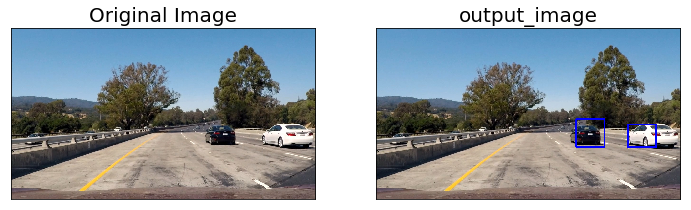

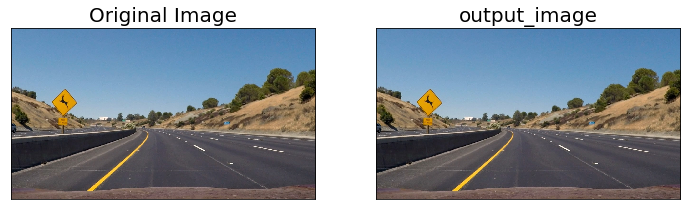

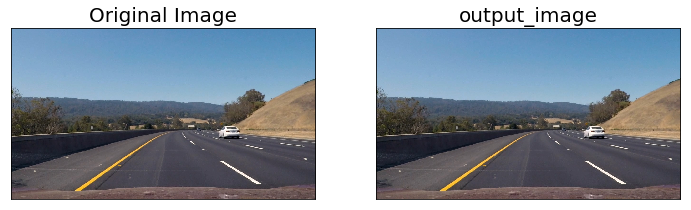

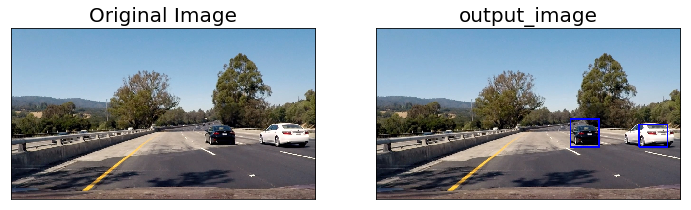

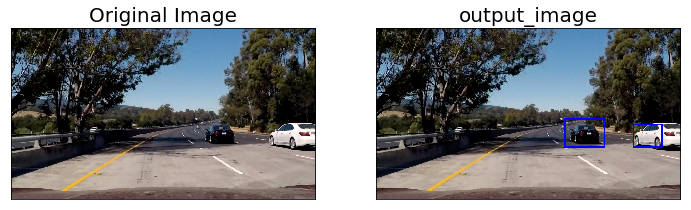

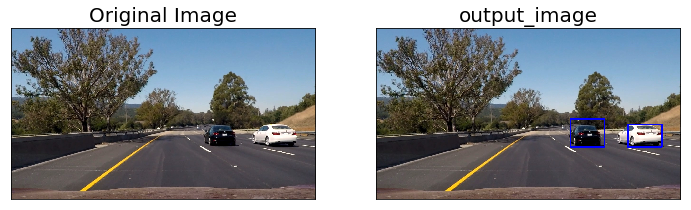

In [11]:
# Load the 6 test images, and save the processed images to a specified directory.

test_images = os.listdir("test_images/")

'''

if not os.path.isdir("output_images"):   # if the folder called 'output_images' does not exist, create this folder
    os.mkdir("output_images")
'''

for B in range(len(test_images)):
    
    single_img = mpimg.imread(os.path.join("test_images", test_images[B]))
    
    #single_img = single_img_original.astype(np.float32)/255
    
    draw_img, bbox_list = find_cars(img=single_img, ystart=single_img.shape[0]//2, ystop=np.int(single_img.shape[0]*0.9),
              scale=1.5, svc=svc , X_scaler=X_scaler, orient=orient,
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_size=spatial_size, hist_bins=hist_bins)
    
    heat = np.zeros_like(single_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox_list)
    
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(single_img), labels)
    
        
    mpimg.imsave(os.path.join("output_images/", test_images[B]), draw_img)
    
    disp_img(single_img,draw_img, aug_title = "output_image")

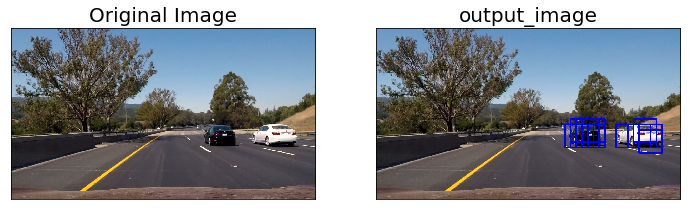

In [12]:
show_img = mpimg.imread('./test_images/test6.jpg')
draw_img, bbox_list = find_cars(img=show_img, ystart=single_img.shape[0]//2, ystop=single_img.shape[0],
              scale=1.5, svc=svc , X_scaler=X_scaler, orient=orient,
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_size=spatial_size, hist_bins=hist_bins)

disp_img(show_img,draw_img, aug_title = "output_image")

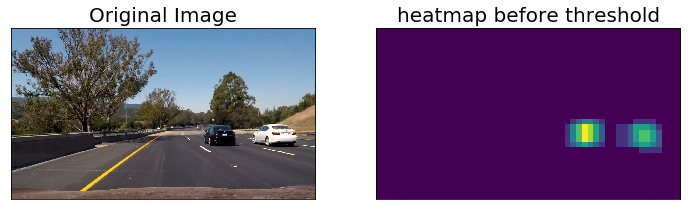

In [13]:
heat = np.zeros_like(show_img[:,:,0]).astype(np.float)
heat = add_heat(heat,bbox_list)
disp_img(show_img,heat, aug_title = "heatmap before threshold")

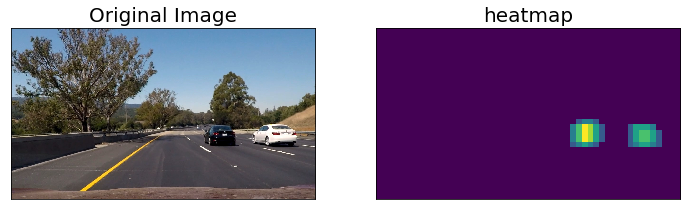

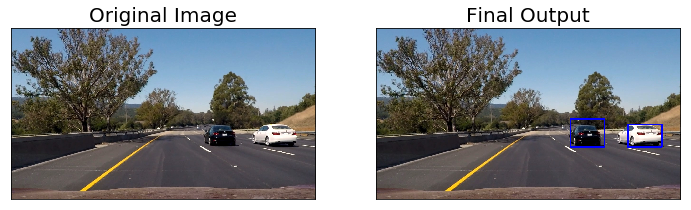

In [14]:
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(show_img), labels)
disp_img(show_img, heatmap, aug_title = "heatmap")
disp_img(show_img, draw_img, aug_title = "Final Output")

<br><br>
<br><br>
### Video Implementation



####  Cell 11

In [15]:
def video_pipeline(img):
    
    image = img
    
    global smooth_count
    
    smooth_window = 23
    
    # apply hog sub-sampling technique
    draw_img, bbox_list = find_cars(img=image, ystart=image.shape[0]//2, ystop=image.shape[0],
              scale=1.5, svc=svc , X_scaler=X_scaler, orient=orient,
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_size=spatial_size, hist_bins=hist_bins)
    
    # add heat map
    boxes.append(bbox_list)
    
    # heat = np.zeros_like(image)
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    
    # Setting threshold for rejecting false positives
    if smooth_count > smooth_window:
        for A in range(smooth_window):
            heat = add_heat(heat, boxes[-A])
        heat = apply_threshold(heat, smooth_window)
    else:
        heat = add_heat(heat, bbox_list)
        heat = apply_threshold(heat, 1)
        
    smooth_count += 1
    
    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    
    draw_img =draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img  

In [16]:
boxes = []
smooth_count = 0

In [17]:
def process_video(video_path, file_out):

    output = file_out
    clip1 = VideoFileClip(video_path)
    # NOTE: this function expects color images!!
    clip = clip1.fl_image(video_pipeline)
    clip.write_videofile(output, audio=False)

In [ ]:
process_video(video_path='test_videos/test_video.mp4', file_out='output_videos/test_out.mp4')

In [ ]:
process_video(video_path='test_videos/project_video.mp4', file_out='output_videos/project_out.mp4')

In [2]:
bg.make_video(video_path ="output_videos/test_out.mp4", file_out = "output_videos/test_output_combined.mp4")

[MoviePy] >>>> Building video output_videos/test_output_combined.mp4
[MoviePy] Writing video output_videos/test_output_combined.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:05<00:00,  7.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_output_combined.mp4 



In [3]:
bg.make_video(video_path ="output_videos/project_out.mp4", file_out = "output_videos/project_output_combined.mp4")

[MoviePy] >>>> Building video output_videos/project_output_combined.mp4
[MoviePy] Writing video output_videos/project_output_combined.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:05<00:00,  7.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_output_combined.mp4 



In [18]:
process_video(video_path='test_videos/extra_video_1.mp4', file_out='output_videos/extra_video_1_out.mp4')

[MoviePy] >>>> Building video output_videos/extra_video_1_out.mp4
[MoviePy] Writing video output_videos/extra_video_1_out.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 4067/4067 [02:55<00:00, 23.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/extra_video_1_out.mp4 



In [19]:
process_video(video_path='test_videos/extra_video_2.mp4', file_out='output_videos/extra_video_2_out.mp4')

[MoviePy] >>>> Building video output_videos/extra_video_2_out.mp4
[MoviePy] Writing video output_videos/extra_video_2_out.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 2270/2270 [01:40<00:00, 22.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/extra_video_2_out.mp4 



In [20]:
process_video(video_path='test_videos/extra_video_3.mp4', file_out='output_videos/extra_video_3_out.mp4')

[MoviePy] >>>> Building video output_videos/extra_video_3_out.mp4
[MoviePy] Writing video output_videos/extra_video_3_out.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 4881/4881 [03:32<00:00, 23.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/extra_video_3_out.mp4 



<BR><BR>
####  References:

* **https://www.github.com**
* **http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html**
* **http://opencv.org/**

<br><br>
<br><br>
<br><br>
<br><br>
<br><br>
### PLEASE IGNORE everything below...
<br><br>

In [ ]:
import numpy as np
a = np.array([[1,2],[3,4],[1,2],[3,4]])

In [ ]:
from scipy.ndimage.measurements import label

labels = label(a)

In [ ]:
labels[0]


In [ ]:
labels[0].nonzero()

In [ ]:
labels[0]==1

In [ ]:
labels[0]==2

In [ ]:
a = [1,2,3]

In [ ]:
a.pop(0)

In [ ]:
a


In [ ]:
def generator(xmin,xmax,ymin,ymax,X_raw):
    
    X_add = []
    
    for i in range(len(X_raw)):
        img = mpimg.imread(X_raw[i])
            
        if ((xmax[i]-xmin[i])*(ymax[i]-ymin[i]))>0:
            
            crop_img = img[ymin[i]:ymax[i],xmin[i]:xmax[i]]

            img_resized = cv2.resize(crop_img, (64,64))  #, interpolation = cv2.INTER_AREA
                
            X_add.append(crop_img)
                
        else:
                
                        
            X_add.append(img)
 
        
    yield X_add


In [ ]:
###### Method One: Slide Window Technique
# Load the 6 test images, and save the processed images to a specified directory.

test_images = os.listdir("test_images/")

if not os.path.isdir("output_images"):   # if the folder called 'output_images' does not exist, create this folder
    os.mkdir("output_images")

fig = plt.figure(figsize = (50,25))

for A in range(len(test_images)):
    
    single_img = mpimg.imread(os.path.join("test_images", test_images[A]))
    
    single_img = single_img.astype(np.float32)/255
    
    window_1=slide_window(img = single_img,x_start_stop=[None, None],
                          y_start_stop=[None, None],xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    hot_windows = search_windows(img = single_img, windows=window_1, clf=svc,
                    scaler=X_scaler, cspace=cspace, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=hist_range, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel)
    
    heatmap_img = np.zeros_like(mpimg.imread(os.path.join("test_images", test_images[A])))
    heatmap_img = add_heat(heatmap = heatmap_img, bbox_list=hot_windows)
    
    labels = label(heatmap_img)
    
    output_img = draw_labeled_bboxes(img=mpimg.imread(os.path.join("test_images", test_images[A])), labels=labels)
    
    mpimg.imsave(os.path.join("output_images", test_images[A]), output_img)
    
    
    fig.add_subplot(2,3,A+1)
    fig.tight_layout()
    plt.imshow(mpimg.imread(os.path.join("test_images", test_images[A])))
    plt.imshow(output_img)
    
    plt.axis('off')
    
plt.show()

In [ ]:
for i in range(15,30,1):
    print(i)